In [ ]:
import torch
from torch.utils.data import DataLoader, Sampler
from torchaudio.datasets import SPEECHCOMMANDS
from transformers import AutoProcessor, ASTModel
import random
import matplotlib.pyplot as plt

# Set the seed for reproducibility
random.seed(42)
torch.manual_seed(42)

/Users/ilerisoy/anaconda3/envs/protonet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize the Configurations

In [2]:
# Configuration
device = "cpu"
n_way = 2
k_shot = 5
q_query = 10
episodes_per_epoch = 5
num_epochs = 10
sample_rate = 16000

# Load the Data and the Model to Train

In [3]:
# Load the dataset
train_set = SPEECHCOMMANDS(root="./dataset", download=True, subset="training")
test_set = SPEECHCOMMANDS(root="./dataset", download=True, subset="testing")

# Initialize the Preprocessor and Model
processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-speech-commands-v2", cache_dir="./models")
model = ASTModel.from_pretrained("MIT/ast-finetuned-speech-commands-v2", cache_dir="./models")
model = model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Dataset Preparation

In [ ]:
class EpisodeSampler(Sampler):
    """
    A sampler that generates episodes for few-shot learning.
    Creates a number of tasks for each epoch based on the specified number of classes, support samples, and query samples.
    """
    def __init__(self, dataset, n_way, k_shot, q_query, episodes_per_epoch):
        self.dataset = dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.episodes = episodes_per_epoch
        self.labels = [datapoint[2] for datapoint in dataset]
        self.classes = sorted(list(set(self.labels)))
        self.class_to_indices = {cls: [i for i, label in enumerate(self.labels) if label == cls] 
                                  for cls in self.classes}

    def __iter__(self):
        for _ in range(self.episodes):
            selected_classes = random.sample(self.classes, self.n_way)
            indices = []
            
            # Separete the support and query indices
            support_indices = []
            query_indices = []
            for cls in selected_classes:
                samples = random.sample(self.class_to_indices[cls], self.k_shot + self.q_query)
                support_indices.extend(samples[:self.k_shot])
                query_indices.extend(samples[self.k_shot:])
            
            # Combine the indices with supports first, and then query
            indices = support_indices + query_indices
            yield indices

    def __len__(self):
        return self.episodes

In [ ]:
def collate_fn(batch):
    """
    Custom collate function that applies the specified pre-processing steps to each batch of data while creating the dataloader.

    Args:
        batch: A list of tuples containing the waveform, sample rate, and label.
    
    Returns:
        spectrograms: Tensor containing the processed spectrograms.
        remapped_labels: Tensor containing the modified labels of the batch for the generated episode.
    """

    # Initialize lists to store waveforms and labels
    waveforms = []
    original_labels = []

    # Separate waveforms and labels
    for waveform, _, label, *_ in batch:
        waveforms.append(waveform)
        original_labels.append(label)
    
    # Process spectrograms using the model's own processor
    spectrograms = []
    for waveform in waveforms:
        inputs = processor(waveform[0], sampling_rate=sample_rate, return_tensors="pt", padding="max_length", max_length=1024, truncation=True
        )
        
        # Processor outputs a dict with keys: dict_keys(['input_values'])
        spectrograms.append(inputs["input_values"])
    
    # Convert spectrograms list to tensors
    spectrograms = torch.cat(spectrograms)
    spectrograms = spectrograms.permute(0, 2, 1)        # Transpose dimensions to (batch_size, num_mel_bins, num_frames)
    spectrograms = torch.clamp(spectrograms, min=1e-7)  # add epsilon to avoid log(0)
    
    # Map original labels to [0, N_way-1] within an episode
    unique_classes = sorted(list(set(original_labels)))
    class_mapping = {cls:i for i, cls in enumerate(unique_classes)}
    remapped_labels = [class_mapping[cls] for cls in original_labels]
    
    # Return the spectrograms and episode labels
    return spectrograms, torch.tensor(remapped_labels)

def euclidean_dist(x, y):
    """
    Function that calculates the Euclidean distance between two tensors.

    Args:
        x: Tensor of shape (N, D) where N is the number of samples and D is the feature dimension.
        y: Tensor of shape (M, D) where M is the number of prototypes and D is the feature dimension.
    
    Returns:
        dist: Tensor of shape (N, M) containing the pairwise Euclidean distances.
    """
    return torch.cdist(x, y, p=2)

def prototypical_loss(prototypes, query_embeddings, query_labels):
    """
    Loss function used for training the model.
    Computes the Euclidean distance between the query embeddings and the prototypes and then applies Cross-entropy loss based on the.
    """
    distances = euclidean_dist(query_embeddings, prototypes)
    loss = torch.nn.functional.cross_entropy(-distances, query_labels)
    return loss

In [ ]:
# Create DataLoaders
train_sampler = EpisodeSampler(train_set, n_way, k_shot, q_query, episodes_per_epoch)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=4 if device == "cuda" else 0
)

# Training Loop

In [ ]:
# Training Setup
print(f"Device: {device}")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
model = model.to(device)
model.train()

# Initialize lists to store epoch losses and accuracies for visualization
epoch_losses = []
epoch_accuracies = []

# Training Loop
for epoch in range(num_epochs):
    correct = 0
    total = 0
    total_loss = 0

    for batch_idx, (spectrograms, labels) in enumerate(train_loader):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)
        
        # Split the batch into support and query
        support_size = n_way * k_shot
        support_specs = spectrograms[:support_size]
        query_specs = spectrograms[support_size:]
        support_labels = labels[:support_size]
        query_labels = labels[support_size:]
            
        # Get the embeddings
        support_out = model(support_specs)
        query_out = model(query_specs)
        support_embeds = support_out.last_hidden_state.mean(dim=1)
        query_embeds = query_out.last_hidden_state.mean(dim=1)
        
        # Compute the prototypes
        prototypes = []
        for c in range(n_way):
            class_mask = (support_labels == c)
            prototypes.append(support_embeds[class_mask].mean(dim=0))
        prototypes = torch.stack(prototypes)
        
        # Calculate the loss
        distances = euclidean_dist(query_embeds, prototypes)
        loss = torch.nn.functional.cross_entropy(-distances, query_labels)
        
        # Backpropagation with gradient clipping
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Accuracy calculation
        with torch.no_grad():
            distances = euclidean_dist(query_embeds, prototypes)
            preds = torch.argmin(distances, dim=1)
            correct += (preds == query_labels).sum().item()
            total += query_labels.numel()
        
        total_loss += loss.item()
    
    # Append the average loss and accuracy for the epoch for visualization
    epoch_losses.append(total_loss / len(train_loader))
    epoch_accuracies.append(correct / total)
    
    # Print epoch loss and accuracy
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | Acc: {correct/total:.4f}")

Device: cpu
Epoch 1 | Loss: 1.5129 | Acc: 0.5300
Epoch 2 | Loss: 0.8064 | Acc: 0.6300
Epoch 3 | Loss: 0.6999 | Acc: 0.6300
Epoch 4 | Loss: 0.5268 | Acc: 0.7700
Epoch 5 | Loss: 0.5920 | Acc: 0.6900
Epoch 6 | Loss: 0.4909 | Acc: 0.7500
Epoch 7 | Loss: 0.4946 | Acc: 0.7700
Epoch 8 | Loss: 0.6735 | Acc: 0.6600
Epoch 9 | Loss: 0.4551 | Acc: 0.8000
Epoch 10 | Loss: 0.2012 | Acc: 0.9300


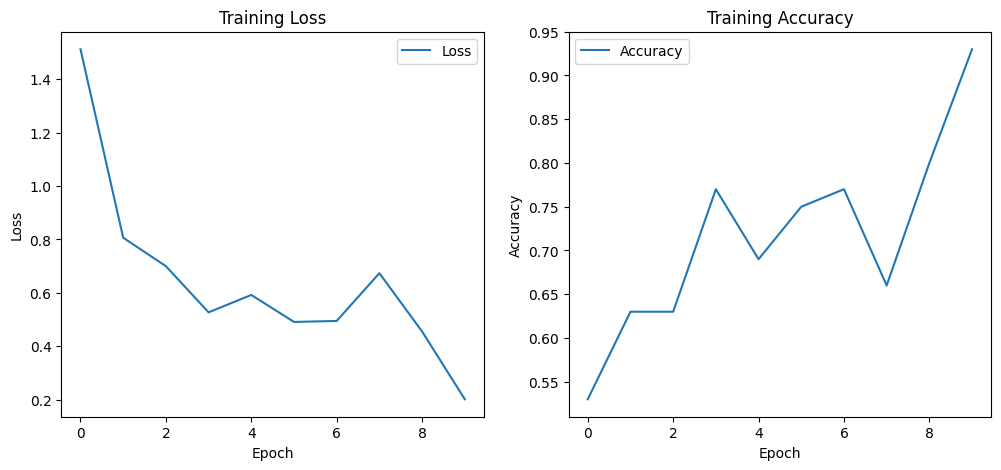

In [8]:
# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# Save the model
torch.save(model.state_dict(), "models/prototypical_network_model.pth")

# Testing

### Define the Testing Function

In [ ]:
def evaluate(model, loader, n_way, k_shot, device):
    """
    Function to evaluate the model on the test set.
    
    Arguments:
        - model: model to evaluate.
        - loader: DataLoader to evaluate the model on.
        - n_way: number of classes in the test episode.
        - k_shot: number of support samples per class.
        - device: device to run the model on.
    
    Returns:
        - accuracy: accuracy of the model on the test set.
    """
    model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch_idx, (spectrograms, labels) in enumerate(loader):
            print(f"Batch {batch_idx+1}/{len(loader)}")
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            support_size = n_way * k_shot
            support_specs = spectrograms[:support_size]
            query_specs = spectrograms[support_size:]
            support_labels = labels[:support_size]
            query_labels = labels[support_size:]
            
            # Get embeddings
            support_embeds = model(support_specs).last_hidden_state.mean(dim=1)
            query_embeds = model(query_specs).last_hidden_state.mean(dim=1)
            
            # Compute prototypes
            prototypes = []
            for c in range(n_way):
                class_mask = (support_labels == c)
                prototypes.append(support_embeds[class_mask].mean(dim=0))
            prototypes = torch.stack(prototypes)
            
            # Calculate accuracy
            distances = euclidean_dist(query_embeds, prototypes)
            preds = torch.argmin(distances, dim=1)
            correct = (preds == query_labels).sum().item()
            
            total_correct += correct
            total_samples += query_labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f"Test Accuracy ({n_way}-way {k_shot}-shot): {accuracy:.4f}")
    return accuracy

## Initialize Models to Test

In [11]:
# Load the raw and trained models
model_trained = ASTModel.from_pretrained("MIT/ast-finetuned-speech-commands-v2")
model_trained.load_state_dict(torch.load("models/prototypical_network_model.pth"))
model_raw = ASTModel.from_pretrained("MIT/ast-finetuned-speech-commands-v2")

## Testing Setup

In [12]:
# Add these configurations at the top with other parameters
test_episodes = 50
test_n_way = 5
test_k_shot = 5
test_q_query = 15

# Create test sampler and loader
test_sampler = EpisodeSampler(
    test_set,
    n_way=test_n_way,
    k_shot=test_k_shot,
    q_query=test_q_query,
    episodes_per_epoch=test_episodes
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=0
)

In [13]:
# Test the trained model
test_acc = evaluate(model_trained, test_loader, test_n_way, test_k_shot, device)

Batch 1/50
Batch 2/50
Batch 3/50
Batch 4/50
Batch 5/50
Batch 6/50
Batch 7/50
Batch 8/50
Batch 9/50
Batch 10/50
Batch 11/50
Batch 12/50
Batch 13/50
Batch 14/50
Batch 15/50
Batch 16/50
Batch 17/50
Batch 18/50
Batch 19/50
Batch 20/50
Batch 21/50
Batch 22/50
Batch 23/50
Batch 24/50
Batch 25/50
Batch 26/50
Batch 27/50
Batch 28/50
Batch 29/50
Batch 30/50
Batch 31/50
Batch 32/50
Batch 33/50
Batch 34/50
Batch 35/50
Batch 36/50
Batch 37/50
Batch 38/50
Batch 39/50
Batch 40/50
Batch 41/50
Batch 42/50
Batch 43/50
Batch 44/50
Batch 45/50
Batch 46/50
Batch 47/50
Batch 48/50
Batch 49/50
Batch 50/50
Test Accuracy (5-way 5-shot): 0.6867


In [14]:
# Test the original model
test_acc = evaluate(model_raw, test_loader, test_n_way, test_k_shot, device)

Batch 1/50
Batch 2/50
Batch 3/50
Batch 4/50
Batch 5/50
Batch 6/50
Batch 7/50
Batch 8/50
Batch 9/50
Batch 10/50
Batch 11/50
Batch 12/50
Batch 13/50
Batch 14/50
Batch 15/50
Batch 16/50
Batch 17/50
Batch 18/50
Batch 19/50
Batch 20/50
Batch 21/50
Batch 22/50
Batch 23/50
Batch 24/50
Batch 25/50
Batch 26/50
Batch 27/50
Batch 28/50
Batch 29/50
Batch 30/50
Batch 31/50
Batch 32/50
Batch 33/50
Batch 34/50
Batch 35/50
Batch 36/50
Batch 37/50
Batch 38/50
Batch 39/50
Batch 40/50
Batch 41/50
Batch 42/50
Batch 43/50
Batch 44/50
Batch 45/50
Batch 46/50
Batch 47/50
Batch 48/50
Batch 49/50
Batch 50/50
Test Accuracy (5-way 5-shot): 0.3072


# Results

Test Accuracy (5-way 5-shot): 0.3072

Test Accuracy (5-way 5-shot): 0.6867